# Import librairies

In [1]:
#from google.colab import drive
#drive.mount('/content/drive/')

In [2]:
#pip install chart_studio numpy pandas matplotlib joblib keras tensorflow scikit-learn plotly seaborn statsmodels scipy

In [3]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib

from keras import optimizers
from keras.utils import plot_model
from keras.models import Sequential, Model
from keras.layers import Conv1D, MaxPooling1D
from keras.layers import Dense, LSTM, SimpleRNN, RepeatVector, TimeDistributed, Flatten
from keras import regularizers
from keras.layers import Dropout

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Bidirectional, LSTM
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.regularizers import l2

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import chart_studio.plotly as py
import plotly.graph_objects as go  # ou plotly.graph_objs, dependendo da versão
from plotly.offline import init_notebook_mode, iplot

# Basic packages
import datetime # manipulating date formats
import seaborn as sns # for prettier plots


# TIME SERIES
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs


# settings
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
warnings.filterwarnings("ignore")
init_notebook_mode(connected=True)

# Set seeds to make the experiment more reproducible.
from tensorflow.random import set_seed
from numpy.random import seed
set_seed(1)
seed(1)

# Pré-processamento dos dados

* Carregando os dados
* Padronizando os dados
* Dividindo em treino, teste e validação

In [12]:
dataframe = pd.read_csv('dataframe.csv')

In [13]:
dataframe.head(5)

,TEMP
0,27.73
1,27.97
2,25.70
3,26.49
4,22.42


In [14]:
data = dataframe.values  # Converte o DataFrame para um array NumPy

## Train test split

In [15]:
# Definindo a proporção para treino, validação e teste
train_size = 0.7
valid_size = 0.15
test_size = 0.15

In [17]:
# Total de dados
total_data_len = len(dataframe)
train_data_len = int(np.floor(total_data_len * train_size))
valid_data_len = int(np.floor(total_data_len * valid_size))
test_data_len = int(np.floor(total_data_len * test_size))
print(total_data_len)
print(train_data_len)
print(valid_data_len)
print(test_data_len)


564
394
84
84


### Criando Treino, Validacao e Teste sem Padronizacao dos dados

In [ ]:
# Criando conjuntos de treinamento
train_data = data[0:train_data_len, :]
X_train, Y_train = [], []
for i in range(60, len(train_data)):
    X_train.append(train_data[i-60:i, 0])
    Y_train.append(train_data[i, 0])

X_train, Y_train = np.array(X_train), np.array(Y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

print(len(X_train))
print(len(Y_train))
print(len(train_data))

In [ ]:
# Criando o conjunto de validação
valid_data = data[train_data_len:train_data_len + valid_data_len, :]
X_valid, Y_valid = [], []

for i in range(60, len(valid_data)):
    X_valid.append(valid_data[i-60:i, 0])
    Y_valid.append(valid_data[i, 0])

X_valid, y_valid = np.array(X_valid), np.array(Y_valid)
X_valid = np.reshape(X_valid, (X_valid.shape[0], X_valid.shape[1], 1))
Y_valid = np.array(Y_valid)

print(len(X_valid))
print(len(Y_valid))
print(len(valid_data))

In [ ]:
# Ajustando o conjunto de teste para garantir que o tamanho de X_test e Y_test sejam iguais
test_data = data[train_data_len + valid_data_len - 60:, :]  # Substitua a linha anterior
Y_test = data[train_data_len + valid_data_len:, :]  # Permanece o mesmo

X_test = []
for i in range(60, len(test_data)):
    X_test.append(test_data[i-60:i, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

print(len(X_test))  # Agora deve corresponder ao tamanho de Y_test
print(len(Y_test))
print(len(test_data))

### Treino, Teste e Validacao com padronizacao dos dados

In [ ]:
# Criando o escalador
scaler = MinMaxScaler()


# Salvar o scaler para uso posterior
joblib.dump(scaler, 'scaler.pkl')


In [ ]:
# Ajustar o scaler com base no conjunto de treinamento
train_data = data[0:train_data_len, :]  # Apenas dados de treino
train_data_scaled = scaler.fit_transform(train_data)  # Padronizando o conjunto de treino

# Criando os conjuntos de treinamento a partir dos dados padronizados
X_train, Y_train = [], []
for i in range(60, len(train_data_scaled)):
    X_train.append(train_data_scaled[i-60:i, 0])  # Sequência de 60 passos
    Y_train.append(train_data_scaled[i, 0])       # Próximo valor a ser previsto

# Convertendo para arrays NumPy
X_train, Y_train = np.array(X_train), np.array(Y_train)

# Ajustando o formato de X_train para 3D, se necessário (séries temporais)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# Verificando os tamanhos
print(f"Tamanhos: X_train={len(X_train)}, Y_train={len(Y_train)}, train_data={len(train_data)}")


In [ ]:
# Criando o conjunto de validação
valid_data = data[train_data_len:train_data_len + valid_data_len, :]  # Dados de validação

# Padronizando o conjunto de validação com o escalador treinado no conjunto de treino
valid_data_scaled = scaler.transform(valid_data)  # Usando o mesmo escalador

# Criando as sequências para o conjunto de validação
X_valid, Y_valid = [], []
for i in range(60, len(valid_data_scaled)):
    X_valid.append(valid_data_scaled[i-60:i, 0])  # Sequência de 60 passos
    Y_valid.append(valid_data_scaled[i, 0])       # Próximo valor a ser previsto

# Convertendo para arrays NumPy
X_valid, Y_valid = np.array(X_valid), np.array(Y_valid)

# Ajustando o formato de X_valid para 3D, se necessário
X_valid = np.reshape(X_valid, (X_valid.shape[0], X_valid.shape[1], 1))

# Verificando os tamanhos
print(f"Tamanhos: X_valid={len(X_valid)}, Y_valid={len(Y_valid)}")

In [ ]:
# # Ajustando o conjunto de teste para garantir que o tamanho de X_test e Y_test sejam iguais
# test_data = data[train_data_len + valid_data_len - 60:, :]  # Dados de teste

# # Padronizando o conjunto de teste com o escalador ajustado no conjunto de treino
# test_data_scaled = scaler.transform(test_data)  # Usando o mesmo escalador

# # Criando as sequências para o conjunto de teste
# X_test = []
# for i in range(60, len(test_data_scaled)):
#     X_test.append(test_data_scaled[i-60:i, 0])  # Sequência de 60 passos

# X_test = np.array(X_test)

# # Ajustando o formato de X_test para 3D, necessário para o modelo LSTM
# X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# # Definindo Y_test (valores reais do conjunto de teste)
# Y_test = data[train_data_len + valid_data_len:, :]  # Isso permanece o mesmo

# print(f"Tamanhos: X_test={len(X_test)}, Y_test={len(Y_test)}")
# print(f"Tamanho de test_data: {len(test_data)}")

In [ ]:
# Ajustando o conjunto de teste para garantir que o tamanho de X_test e Y_test sejam iguais
test_data = data[train_data_len + valid_data_len - 60:, :]  # Dados de teste

# Padronizando o conjunto de teste com o escalador ajustado no conjunto de treino
test_data_scaled = scaler.transform(test_data)  # Usando o mesmo escalador


X_test, Y_test = [], []
for i in range(60, len(test_data)):
    X_test.append(test_data_scaled[i-60:i, 0])  # Sequência de 60 passos
    Y_test.append(test_data_scaled[i, 0])       # Próximo valor a ser previsto


X_test = np.array(X_test), np.array(Y_test)


print(f"Tamanhos: X_test={len(X_test)}, Y_test={len(Y_test)}")
print(f"Tamanho de test_data: {len(test_data)}")

# Ajustando o conjunto de teste para garantir que o tamanho de X_test e Y_test sejam iguais
test_data = data[train_data_len + valid_data_len - 60:, :]  # Substitua a linha anterior
Y_test = data[train_data_len + valid_data_len:, :]  # Permanece o mesmo

X_test = []
for i in range(60, len(test_data)):
    X_test.append(test_data[i-60:i, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

print(len(X_test))  # Agora deve corresponder ao tamanho de Y_test
print(len(Y_test))
print(len(test_data))

In [ ]:
# Ajustando o conjunto de teste para garantir que o tamanho de X_test e Y_test sejam iguais
test_data = data[train_data_len + valid_data_len - 60:, :]  # Substitua a linha anterior
Y_test = data[train_data_len + valid_data_len:, :]  # Permanece o mesmo

X_test = []
for i in range(60, len(test_data)):
    X_test.append(test_data[i-60:i, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

print(len(X_test))  # Agora deve corresponder ao tamanho de Y_test
print(len(Y_test))
print(len(test_data))

### Ajuste da Padronização do Treino e Teste

In [52]:
# Definir o número de passos de entrada e saída
n_steps_in, n_steps_out = 10, 1

# Transformar de Series Temporais para Amostras e Saída
def create_supervised_data(data, n_steps_in, n_steps_out):
    X, Y = [], []
    for i in range(len(data) - n_steps_in - n_steps_out + 1):
        X.append(data[i:i + n_steps_in, 0])  # Todas as colunas, exceto a última
        Y.append(data[i + n_steps_in:i + n_steps_in + n_steps_out, 0])  # Apenas a última coluna
    return np.array(X), np.array(Y)

In [65]:
# Definir proporção de treino (70%)
train_size = int(len(data) * 0.7)

# Dividir o conjunto de treino
train_data = data[:train_size]

# Padronizar o conjunto de treino
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_data)

X_train, Y_train = create_supervised_data(train_scaled, n_steps_in, n_steps_out)

# Verificar shapes do conjunto de treino
print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)


X_train shape: (384, 10)
Y_train shape: (384, 1)


In [67]:
# Definir proporção de validação (15% do total)
valid_size = int(len(data) * 0.15)

# Dividir o conjunto de validação
valid_data = data[train_size:train_size + valid_size]

# Padronizar o conjunto de validação (usando parâmetros do treino)
valid_scaled = scaler.transform(valid_data)

# Criar dados supervisionados para validação
X_valid, Y_valid = create_supervised_data(valid_scaled, n_steps_in, n_steps_out)

# Verificar shapes do conjunto de validação
print("X_valid shape:", X_valid.shape)
print("Y_valid shape:", Y_valid.shape)


X_valid shape: (74, 10)
Y_valid shape: (74, 1)


In [68]:
# O restante dos dados será usado para teste
test_data = data[train_size + valid_size:]

# Padronizar o conjunto de teste (usando parâmetros do treino)
test_scaled = scaler.transform(test_data)

# Criar dados supervisionados para teste
X_test, Y_test = create_supervised_data(test_scaled, n_steps_in, n_steps_out)

# Verificar shapes do conjunto de teste
print("X_test shape:", X_test.shape)
print("Y_test shape:", Y_test.shape)


X_test shape: (76, 10)
Y_test shape: (76, 1)


### Tamanho do Dataframe Treino, Teste e Validação

In [70]:
print(f'X_train length: {len(X_train)}')
print(f'Y_train length: {len(Y_train)}')
print(f'X_valid length: {len(X_valid)}')
print(f'Y_valid length: {len(Y_valid)}')
print(f'X_test length: {len(X_test)}')
print(f'Y_test length: {len(Y_test)}')

X_train length: 384
Y_train length: 384
X_valid length: 74
Y_valid length: 74
X_test length: 76
Y_test length: 76


## Ajuste dos dados para os modelos LSTM e CNN

In [71]:
X_train_series = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_valid_series = X_valid.reshape((X_valid.shape[0], X_valid.shape[1], 1))
X_test_series = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

print('Train set shape', X_train_series.shape)
print('Validation set shape', X_valid_series.shape)
print('Test set shape', X_test_series.shape)

Train set shape (384, 10, 1)
Validation set shape (74, 10, 1)
Test set shape (76, 10, 1)


In [ ]:
# def create_sequences(data, seq_length):
#     sequences = []
#     labels = []
#     for i in range(len(data) - seq_length):
#         sequence = data[i:i+seq_length]
#         label = data[i+seq_length]
#         sequences.append(sequence)
#         labels.append(label)
#     return np.array(sequences), np.array(labels)

# # Defina o comprimento da sequência
# seq_length = 30
# X_train_series, Y_train_series = create_sequences(scaled_data, seq_length)
# print('Train set shape', X_trains_series.shape)
# print('Validation set shape', X_valid.shape)
# print('Test set shape', X_test.shape)

# Funções de Métricas Utilizadas e Plot dos Resultados

In [4]:
# # Função para calcular MAPE
# def mean_absolute_percentage_error(y_true, y_pred):
#     y_true, y_pred = np.array(y_true), np.array(y_pred)
#     return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [5]:
# # Função para calcular MSE
# def mean_squared_error(y_true, y_pred):
#     return np.mean((y_true - y_pred) ** 2)


In [6]:
# # Função para calcular RMSE
# def root_mean_squared_error(y_true, y_pred):
#     return np.sqrt(mean_squared_error(y_true, y_pred))

In [7]:
# Função para calcular e exibir as métricas de cada modelo
def evaluate_model(model, X_test, Y_test, model_name="Modelo"):
    # Realiza as previsões no conjunto de teste
    Y_pred = model.predict(X_test)

    # Calcula as métricas
    mae = mean_absolute_error(Y_test, Y_pred)
    mse = mean_squared_error(Y_test, Y_pred)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((Y_test - Y_pred) / Y_test)) * 100

    # Exibe os resultados
    print(f"\n{model_name}:")
    print(f"MAE: {mae:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAPE: {mape:.4f}%")

    return mae, mse, rmse, mape

In [8]:
# Função para exibir os gráficos lado a lado
def plot_multiple_predictions(train_valid_data, y_test, y_pred_models, model_names):
    # Definindo o tamanho da figura e o layout (2 gráficos por linha)
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()  # Achata o array de eixos para indexação direta

    for idx, (y_pred, model_name) in enumerate(zip(y_pred_models, model_names)):
        ax = axes[idx]

        # Plot dos dados de treino e validação
        ax.plot(range(len(train_valid_data)), train_valid_data, label="Dados de Treinamento e Validação", color="blue")

        # Plot dos dados de teste
        ax.plot(range(len(train_valid_data), len(train_valid_data) + len(y_test)), y_test, label="Dados de Teste", color="green")

        # Plot das previsões
        ax.plot(range(len(train_valid_data), len(train_valid_data) + len(y_test)), y_pred, label=f"Previsão {model_name}", color="red", linestyle="--")

        # Configurações do gráfico
        ax.set_title(f'Ajuste do Modelo com Previsões: {model_name}')
        ax.set_xlabel("Tempo")
        ax.set_ylabel("Valor")
        ax.legend()

    # Ajusta o layout e exibe
    plt.tight_layout()
    plt.show()

In [9]:
def plot_multiple_loss(history_standard, history_reg, history_drop, history_reg_drop):

    # Gráficos de ajuste combinado no conjunto de treinamento e validação e previsão no conjunto de teste
    plt.figure(figsize=(14, 10))

    # Modelo Simples
    plt.subplot(2, 2, 1)
    plt.plot(history_standard.history['loss'], label='Treinamento')
    plt.plot(history_standard.history['val_loss'], label='Validação')
    plt.title('Modelo Simples: Perda durante o Treinamento')
    plt.xlabel('Épocas')
    plt.ylabel('Perda')
    plt.legend()

    # Modelo com Regularização
    plt.subplot(2, 2, 2)
    plt.plot(history_reg.history['loss'], label='Treinamento')
    plt.plot(history_reg.history['val_loss'], label='Validação')
    plt.title('Modelo com Regularização: Perda durante o Treinamento')
    plt.xlabel('Épocas')
    plt.ylabel('Perda')
    plt.legend()

    # Modelo com Dropout
    plt.subplot(2, 2, 3)
    plt.plot(history_drop.history['loss'], label='Treinamento')
    plt.plot(history_drop.history['val_loss'], label='Validação')
    plt.title('Modelo com Dropout: Perda durante o Treinamento')
    plt.xlabel('Épocas')
    plt.ylabel('Perda')
    plt.legend()

    # Modelo com Regularização e Dropout
    plt.subplot(2, 2, 4)
    plt.plot(history_reg_drop.history['loss'], label='Treinamento')
    plt.plot(history_reg_drop.history['val_loss'], label='Validação')
    plt.title('Modelo com Regularização e Dropout: Perda durante o Treinamento')
    plt.xlabel('Épocas')
    plt.ylabel('Perda')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [10]:
def plot_predicts(y_pred, y_pred_reg, y_pred_drop, y_pred_reg_drop):

    # Gráficos de predição
    plt.figure(figsize=(14, 10))

    # Modelo Simples
    plt.subplot(2, 2, 1)
    plt.plot(Y_test, label='Real', color='blue')
    plt.plot(y_pred, label='Predito (Simples)', color='red')
    plt.title('Modelo Simples')
    plt.xlabel('Tempo')
    plt.ylabel('Valor')
    plt.legend()

    # Modelo com Regularização
    plt.subplot(2, 2, 2)
    plt.plot(Y_test, label='Real', color='blue')
    plt.plot(y_pred_reg, label='Predito (Reg)', color='red')
    plt.title('Modelo com Regularização')
    plt.xlabel('Tempo')
    plt.ylabel('Valor')
    plt.legend()

    # Modelo com Dropout
    plt.subplot(2, 2, 3)
    plt.plot(Y_test, label='Real', color='blue')
    plt.plot(y_pred_drop, label='Predito (Drop)', color='red')
    plt.title('Modelo com Dropout')
    plt.xlabel('Tempo')
    plt.ylabel('Valor')
    plt.legend()

    # Modelo com Regularização e Dropout
    plt.subplot(2, 2, 4)
    plt.plot(Y_test, label='Real', color='blue')
    plt.plot(y_pred_reg_drop, label='Predito (Reg + Drop)', color='red')
    plt.title('Modelo com Regularização e Dropout')
    plt.xlabel('Tempo')
    plt.ylabel('Valor')
    plt.legend()

    plt.tight_layout()
    plt.show()

# MLP for Time Series Forecasting

* First we will use a Multilayer Perceptron model or MLP model, here our model will have input features equal to the window size.
* The thing with MLP models is that the model don't take the input as sequenced data, so for the model, it is just receiving inputs and don't treat them as sequenced data, that may be a problem since the model won't see the data with the sequence patter that it has.
* Input shape **[samples, timesteps]**.

### Selecao de Hiperparametros

In [72]:
epochs_mlp = 50
batch_mlp = 32
lr = 0.001

### Implementacao e ajuste do Modelo MLP

In [73]:
model_mlp = Sequential()
model_mlp.add(Dense(64, activation='relu', input_dim=X_train.shape[1]))
model_mlp.add(Dense(32))
model_mlp.add(Dense(1))
model_mlp.compile(loss='mean_squared_error', optimizer=optimizers.Adam(lr))
# model_mlp.summary()

In [74]:
#history_mlp = model_mlp.fit(X_train, Y_train,
#                            validation_data=(X_valid, Y_valid),
#                            epochs=epochs_mlp,
#                            verbose=2)

history_mlp = model_mlp.fit(X_train,
                            Y_train,
                            validation_data=(X_valid, Y_valid),
                            epochs=epochs_mlp,
                            batch_size=batch_mlp,
                            verbose=1)

Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 0.1739 - val_loss: 0.0719
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0624 - val_loss: 0.0222
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0225 - val_loss: 0.0203
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0199 - val_loss: 0.0168
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0166 - val_loss: 0.0147
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0155 - val_loss: 0.0138
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0148 - val_loss: 0.0133
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0142 - val_loss: 0.0128
Epoch 9/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0138 - val_loss: 0.0123
Epoch 10/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0135 - val_loss: 0.0120
Epoch 11/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0134 - val_loss: 0.0118
Epoch 12/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0132 - v

### Implementacao e Ajuste do Modelo MLP com regularização

In [75]:
model_mlp_reg = Sequential()
model_mlp_reg.add(Dense(64, activation='relu', input_dim=X_train.shape[1],
                     kernel_regularizer=regularizers.l2(0.01)))  # Regularização L2
model_mlp_reg.add(Dense(32, activation='relu',
                     kernel_regularizer=regularizers.l2(0.01)))  # Regularização L2
model_mlp_reg.add(Dense(1))  # Saída
model_mlp_reg.compile(loss='mean_squared_error', optimizer=optimizers.Adam(lr))
# model_mlp_reg.summary()

In [76]:
#history_mlp_reg = model_mlp_reg.fit(X_train, Y_train,
#                           validation_data=(X_valid, Y_valid),
#                            epochs=epochs_mlp,
#                            verbose=2)

history_mlp_reg = model_mlp_reg.fit(X_train,
                                    Y_train,
                                    validation_data=(X_valid, Y_valid),
                                    epochs=epochs_mlp,
                                    batch_size=batch_mlp,
                                    verbose=1)

Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - loss: 0.8579 - val_loss: 0.6141
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5888 - val_loss: 0.5456
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5349 - val_loss: 0.4851
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.4754 - val_loss: 0.4413
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.4311 - val_loss: 0.3993
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.3911 - val_loss: 0.3635
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.3557 - val_loss: 0.3312
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.3241 - val_loss: 0.3017
Epoch 9/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2954 - val_loss: 0.2752
Epoch 10/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2696 - val_loss: 0.2514
Epoch 11/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2464 - val_loss: 0.2298
Epoch 12/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2254 

### Implementacao e ajuste do modelo MLP com Dropout

In [77]:
model_mlp_drop = Sequential()
model_mlp_drop.add(Dense(64, activation='relu', input_dim=X_train.shape[1]))
model_mlp_drop.add(Dropout(0.3))
model_mlp_drop.add(Dense(32, activation='relu'))
model_mlp_drop.add(Dropout(0.3))
model_mlp_drop.add(Dense(1))
model_mlp_drop.compile(loss='mean_squared_error', optimizer=optimizers.Adam(lr))
# model_mlp_dropout.summary()



In [78]:
#history_mlp_drop = model_mlp_dropout.fit(X_train, Y_train,
#                            validation_data=(X_valid, Y_valid),
#                            epochs=epochs_mlp,
#                            verbose=2)

history_mlp_drop = model_mlp_drop.fit(X_train,
                                        Y_train,
                                        validation_data=(X_valid, Y_valid),
                                        epochs=epochs_mlp,
                                        batch_size=batch_mlp,
                                        verbose=1)

Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - loss: 0.5378 - val_loss: 0.1452
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.1802 - val_loss: 0.0755
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1352 - val_loss: 0.0614
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0986 - val_loss: 0.0512
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0749 - val_loss: 0.0407
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0649 - val_loss: 0.0301
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0551 - val_loss: 0.0303
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0500 - val_loss: 0.0268
Epoch 9/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0412 - val_loss: 0.0199
Epoch 10/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0420 - val_loss: 0.0222
Epoch 11/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0388 - val_loss: 0.0261
Epoch 12/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.040

### Implementando e Ajustando modelo MLP com Regularização e Dropout

In [79]:
# Definição do modelo MLP com regularização e dropout
model_mlp_reg_drop = Sequential()
model_mlp_reg_drop.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=l2(0.001)))
model_mlp_reg_drop.add(Dropout(0.3))  # Taxa de dropout de 20%
model_mlp_reg_drop.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
model_mlp_reg_drop.add(Dropout(0.3))
model_mlp_reg_drop.add(Dense(1))  # Camada de saída
model_mlp_reg_drop.compile(optimizer=optimizers.Adam(lr), loss='mse', metrics=['mae'])

In [80]:
history_mlp_reg_drop = model_mlp_reg_drop.fit(X_train,
                                              Y_train,
                                              validation_data=(X_valid, Y_valid),
                                              epochs=epochs_mlp,
                                              batch_size=batch_mlp,
                                              verbose=1)


Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - loss: 0.2981 - mae: 0.3609 - val_loss: 0.1421 - val_mae: 0.1811
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1640 - mae: 0.2126 - val_loss: 0.1270 - val_mae: 0.1677
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1384 - mae: 0.1843 - val_loss: 0.0958 - val_mae: 0.0970
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1315 - mae: 0.1827 - val_loss: 0.0980 - val_mae: 0.1254
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1139 - mae: 0.1556 - val_loss: 0.0845 - val_mae: 0.0976
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1032 - mae: 0.1483 - val_loss: 0.0833 - val_mae: 0.1082
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1018 - mae: 0.1546 - val_loss: 0.0783 - val_mae: 0.1031
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0940 - mae: 0.1443 - val_loss: 0.0777 - val_mae: 0.1136
Epoch 9/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0852 -

## Comparando os 4 modelos

In [81]:
# Avaliação de cada modelo no conjunto de teste
mae_standard, mse_standard, rmse_standard, mape_standard = evaluate_model(model_mlp, X_test, Y_test, "Modelo Padrão")
mae_reg, mse_reg, rmse_reg, mape_reg = evaluate_model(model_mlp_reg, X_test, Y_test, "Modelo com Regularização")
mae_dropout, mse_dropout, rmse_dropout, mape_dropout = evaluate_model(model_mlp_drop, X_test, Y_test, "Modelo com Dropout")
mae_reg_drop, mse_reg_drop, rmse_reg_drop, mape_reg_drop = evaluate_model(model_mlp_reg_drop, X_test, Y_test, "Modelo com Regularização e Dropout")


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step

Modelo Padrão:
MAE: 0.0810
MSE: 0.0105
RMSE: 0.1022
MAPE: 18.2675%
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step

Modelo com Regularização:
MAE: 0.0962
MSE: 0.0151
RMSE: 0.1230
MAPE: 19.9173%
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/stepWARNING:tensorflow:6 out of the last 9 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x0000020482D65440> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
3/3 ━━━━━━━━━

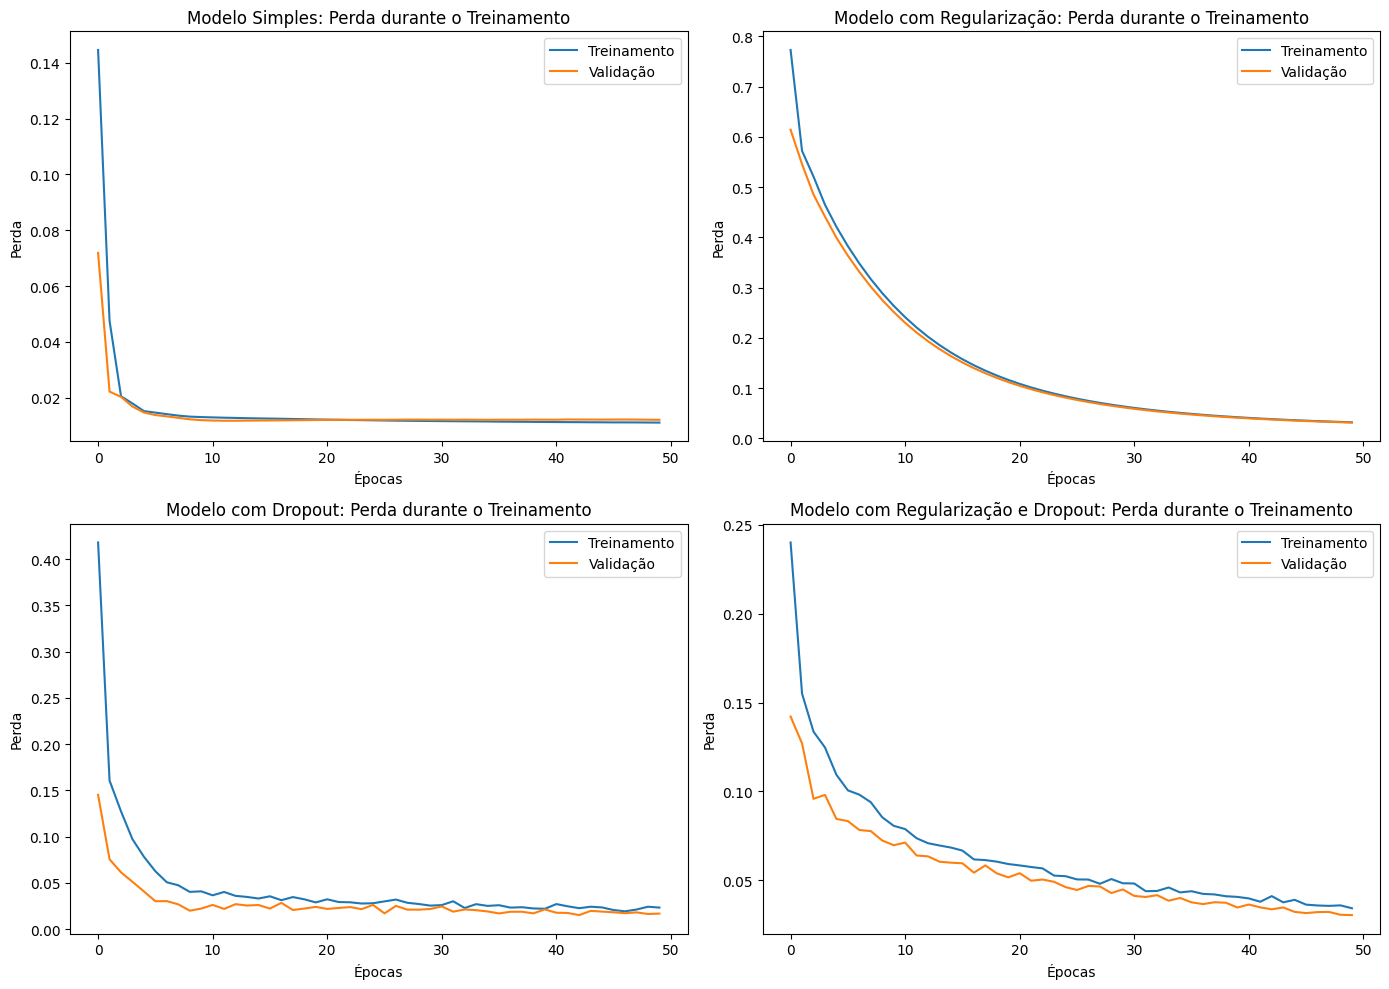

In [82]:
#Plot do Grafico de Perda
plot_multiple_loss(history_mlp, history_mlp_reg, history_mlp_drop, history_mlp_reg_drop)

In [83]:
# Gerando previsões para cada modelo
y_pred_mlp = model_mlp.predict(X_test)
y_pred_mlp_reg = model_mlp_reg.predict(X_test)
y_pred_mlp_drop = model_mlp_drop.predict(X_test)
y_pred_mlp_reg_drop = model_mlp_reg_drop.predict(X_test)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


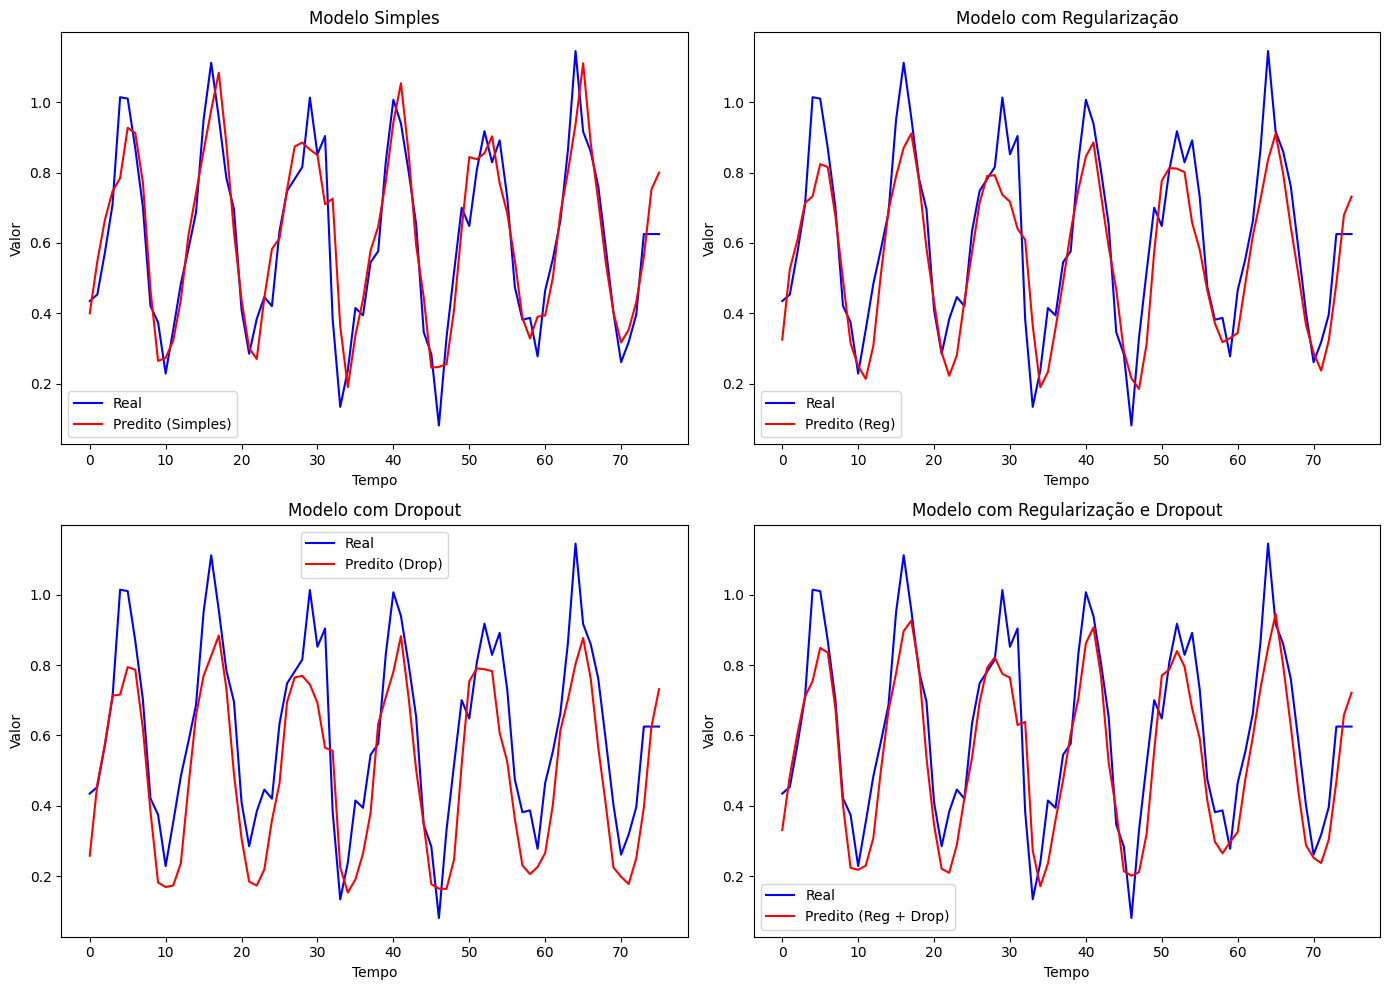

In [84]:
plot_predicts(y_pred_mlp, y_pred_mlp_reg, y_pred_mlp_drop, y_pred_mlp_reg_drop)

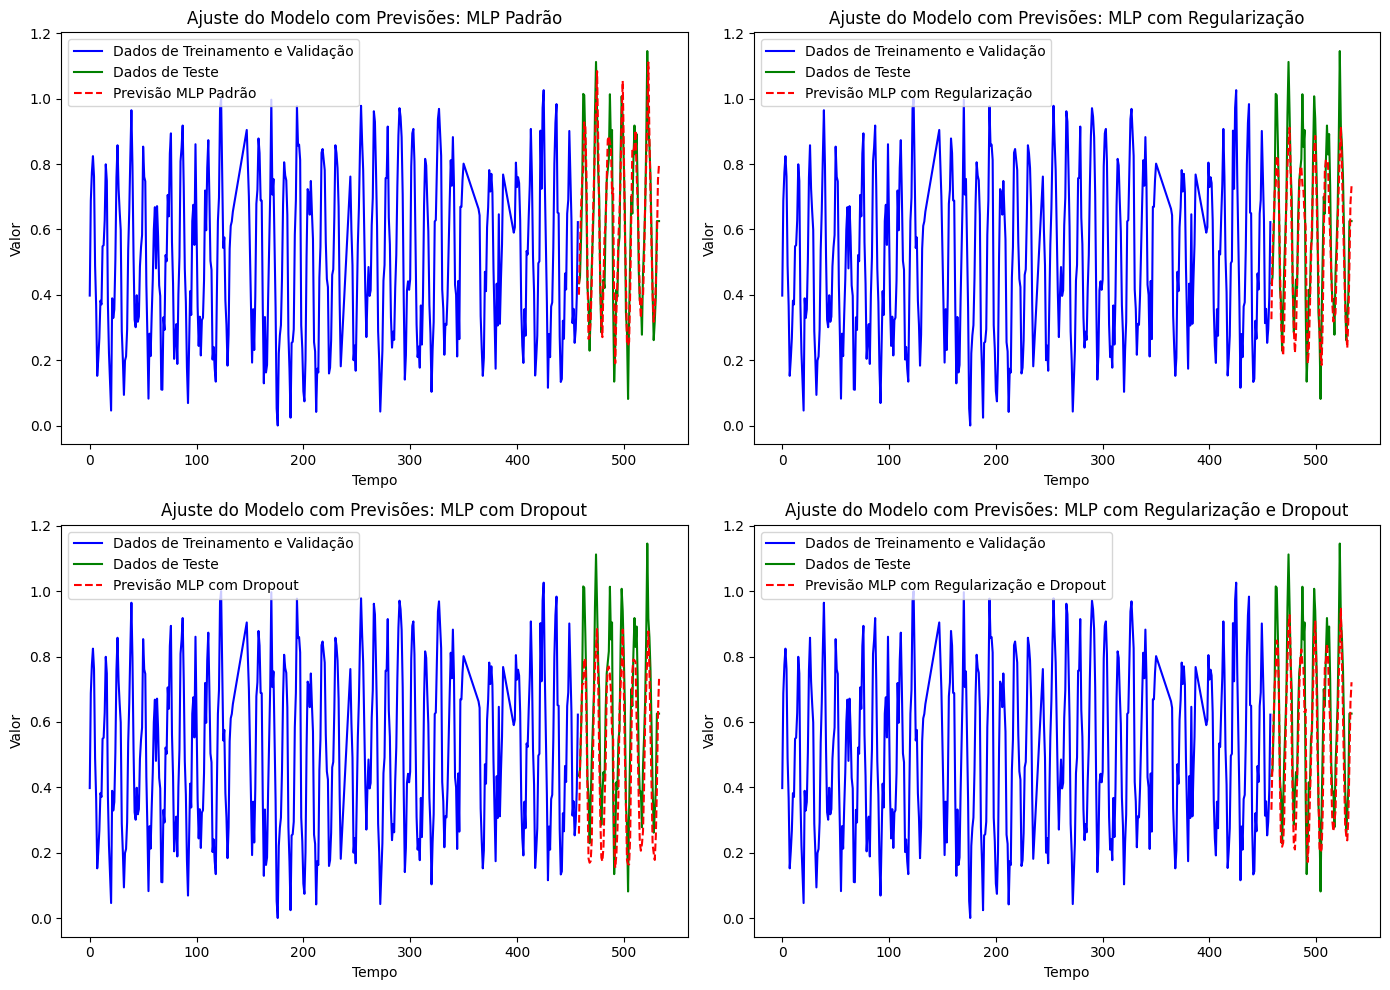

In [85]:
# Combine os dados de treino e validação em uma série para comparação visual com o conjunto de teste e previsões.
train_valid_data = np.concatenate([Y_train, Y_valid])  # Combina Y_train e Y_valid em uma série contínua

# Lista com previsões e nomes dos modelos para plotar
y_pred_models = [y_pred_mlp, y_pred_mlp_reg, y_pred_mlp_drop, y_pred_mlp_reg_drop]
model_names = ["MLP Padrão", "MLP com Regularização", "MLP com Dropout", "MLP com Regularização e Dropout"]

# Chamando a função para exibir os gráficos lado a lado
plot_multiple_predictions(train_valid_data, Y_test, y_pred_models, model_names)


# CNN for Time Series Forecasting

* For the CNN model we will use one convolutional hidden layer followed by a max pooling layer. The filter maps are then flattened before being interpreted by a Dense layer and outputting a prediction.
* The convolutional layer should be able to identify patterns between the timesteps.
* Input shape **[samples, timesteps, features]**.

#### Data preprocess
* Reshape from [samples, timesteps] into [samples, timesteps, features].
* This same reshaped data will be used on the CNN and the LSTM model.

## Seleção de Hiperparametros

In [86]:
#Hiperparametros
epochs_cnn = 30
batch_cnn = 32
lr_cnn = 0.001
#adam = optimizers.Adam(lr)


## Implementando e Ajustando Modelo CNN

In [87]:
model_cnn = Sequential()
model_cnn.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Flatten())
model_cnn.add(Dense(50, activation='relu'))
model_cnn.add(Dense(1))
model_cnn.compile(loss='mse', optimizer=optimizers.Adam(lr_cnn))
# model_cnn.summary()

In [88]:
#history_cnn = model_cnn.fit(X_train_series, Y_train,
#                            validation_data=(X_valid_series, Y_valid),
#                            epochs=epochs_cnn,
#                            verbose=2)

history_cnn = model_cnn.fit(X_train,
                            Y_train,
                            validation_data=(X_valid, Y_valid),
                            epochs=epochs_cnn,
                            batch_size=batch_cnn,
                            verbose=1)

Epoch 1/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - loss: 0.2333 - val_loss: 0.0827
Epoch 2/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0960 - val_loss: 0.0664
Epoch 3/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0675 - val_loss: 0.0526
Epoch 4/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0515 - val_loss: 0.0386
Epoch 5/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0380 - val_loss: 0.0308
Epoch 6/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0284 - val_loss: 0.0249
Epoch 7/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0231 - val_loss: 0.0231
Epoch 8/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0207 - val_loss: 0.0221
Epoch 9/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0198 - val_loss: 0.0218
Epoch 10/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0195 - val_loss: 0.0215
Epoch 11/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0192 - val_loss: 0.0213
Epoch 12/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.019

## Implementando e Ajustando Modelo CNN com Regularização L2

In [89]:
model_cnn_reg = Sequential()
model_cnn_reg.add(Conv1D(filters=64, kernel_size=2, activation='relu',
                         kernel_regularizer=regularizers.l2(0.01),  # Regularização L2
                         input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_cnn_reg.add(MaxPooling1D(pool_size=2))
model_cnn_reg.add(Flatten())
model_cnn_reg.add(Dense(50, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model_cnn_reg.add(Dense(1))
model_cnn_reg.compile(loss='mse', optimizer=optimizers.Adam(lr_cnn))
# model_cnn_reg.summary()


In [90]:
#history_cnn_reg = model_cnn_reg.fit(X_train_series, Y_train,
#                            validation_data=(X_valid_series, Y_valid),
#                            epochs=epochs_cnn,
#                            verbose=2)

history_cnn_reg = model_cnn_reg.fit(X_train_series,
                                    Y_train,
                                    validation_data=(X_valid_series, Y_valid),
                                    epochs=epochs_cnn,
                                    batch_size=batch_cnn,
                                    verbose=1)

Epoch 1/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - loss: 1.1180 - val_loss: 0.8129
Epoch 2/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.7937 - val_loss: 0.6644
Epoch 3/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.6384 - val_loss: 0.5417
Epoch 4/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.5185 - val_loss: 0.4374
Epoch 5/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.4211 - val_loss: 0.3596
Epoch 6/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.3450 - val_loss: 0.2966
Epoch 7/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2855 - val_loss: 0.2489
Epoch 8/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2395 - val_loss: 0.2110
Epoch 9/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2033 - val_loss: 0.1809
Epoch 10/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1748 - val_loss: 0.1571
Epoch 11/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1521 - val_loss: 0.1379
Epoch 12/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.134

## Implementando e Ajustando Modelo CNN com Dropout

In [91]:
model_cnn_drop = Sequential()
model_cnn_drop.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_cnn_drop.add(MaxPooling1D(pool_size=2))
model_cnn_drop.add(Dropout(0.3))
model_cnn_drop.add(Flatten())
model_cnn_drop.add(Dense(50, activation='relu'))
model_cnn_drop.add(Dropout(0.3))
model_cnn_drop.add(Dense(1))
model_cnn_drop.compile(loss='mse', optimizer=optimizers.Adam(lr_cnn))
# model_cnn_drop.summary()

In [92]:
#history_cnn_drop = model_cnn_drop.fit(X_train_series, Y_train,
#                                       validation_data=(X_valid_series, Y_valid),
#                                       epochs=epochs_cnn,
#                                       verbose=2)

history_cnn_drop = model_cnn_drop.fit(X_train_series,
                                    Y_train,
                                    validation_data=(X_valid_series, Y_valid),
                                    epochs=epochs_cnn,
                                    batch_size=batch_cnn,
                                    verbose=1)

Epoch 1/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 0.2147 - val_loss: 0.0874
Epoch 2/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.1153 - val_loss: 0.0657
Epoch 3/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0791 - val_loss: 0.0474
Epoch 4/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0614 - val_loss: 0.0332
Epoch 5/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0448 - val_loss: 0.0274
Epoch 6/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0367 - val_loss: 0.0265
Epoch 7/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0330 - val_loss: 0.0237
Epoch 8/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0310 - val_loss: 0.0244
Epoch 9/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0321 - val_loss: 0.0243
Epoch 10/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0282 - val_loss: 0.0237
Epoch 11/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0284 - val_loss: 0.0220
Epoch 12/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.02

## Implementando e Ajustando Modelo CNN com Regularização e Dropout

In [93]:
model_cnn_reg_drop = Sequential()
model_cnn_reg_drop.add(Conv1D(filters=64, kernel_size=2, activation='relu',
                             kernel_regularizer=regularizers.l2(0.01),
                             input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_cnn_reg_drop.add(MaxPooling1D(pool_size=2))
model_cnn_reg_drop.add(Dropout(0.3))
model_cnn_reg_drop.add(Flatten())
model_cnn_reg_drop.add(Dense(50, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model_cnn_reg_drop.add(Dropout(0.3))
model_cnn_reg_drop.add(Dense(1))
model_cnn_reg_drop.compile(loss='mse', optimizer=optimizers.Adam(lr_cnn))
# model_cnn_reg_drop.summary()

In [94]:
#history_cnn_reg_drop = model_cnn_reg_drop.fit(X_train_series, Y_train,
#                                             validation_data=(X_valid_series, Y_valid),
#                                             epochs=epochs_cnn,
#                                             verbose=2)

history_cnn_reg_drop = model_cnn_reg_drop.fit(X_train_series,
                                            Y_train,
                                            validation_data=(X_valid_series, Y_valid),
                                            epochs=epochs_cnn,
                                            batch_size=batch_cnn,
                                            verbose=1)

Epoch 1/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - loss: 1.0003 - val_loss: 0.7768
Epoch 2/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.7670 - val_loss: 0.6199
Epoch 3/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.6036 - val_loss: 0.4941
Epoch 4/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.4827 - val_loss: 0.3914
Epoch 5/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.3913 - val_loss: 0.3128
Epoch 6/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3186 - val_loss: 0.2560
Epoch 7/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2589 - val_loss: 0.2084
Epoch 8/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2126 - val_loss: 0.1740
Epoch 9/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.1770 - val_loss: 0.1463
Epoch 10/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1518 - val_loss: 0.1264
Epoch 11/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1331 - val_loss: 0.1095
Epoch 12/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1

## Comparando os 4 Modelos CNN

In [95]:
# Previsões
y_pred_cnn = model_cnn.predict(X_test)
y_pred_cnn_reg = model_cnn_reg.predict(X_test)
y_pred_cnn_drop = model_cnn_drop.predict(X_test)
y_pred_cnn_reg_drop = model_cnn_reg_drop.predict(X_test)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


In [96]:
# Avaliação de cada modelo no conjunto de teste
mae_standard, mse_standard, rmse_standard, mape_standard = evaluate_model(model_cnn, X_test, Y_test, "Modelo Padrão")
mae_reg, mse_reg, rmse_reg, mape_reg = evaluate_model(model_cnn_reg, X_test, Y_test, "Modelo com Regularização")
mae_dropout, mse_dropout, rmse_dropout, mape_dropout = evaluate_model(model_cnn_drop, X_test, Y_test, "Modelo com Dropout")
mae_reg_drop, mse_reg_drop, rmse_reg_drop, mape_reg_drop = evaluate_model(model_cnn_reg_drop, X_test, Y_test, "Modelo com Regularização e Dropout")


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 

Modelo Padrão:
MAE: 0.1017
MSE: 0.0171
RMSE: 0.1309
MAPE: 21.2678%
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  

Modelo com Regularização:
MAE: 0.1305
MSE: 0.0260
RMSE: 0.1613
MAPE: 25.4196%
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

Modelo com Dropout:
MAE: 0.1151
MSE: 0.0221
RMSE: 0.1487
MAPE: 22.3148%
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

Modelo com Regularização e Dropout:
MAE: 0.1437
MSE: 0.0310
RMSE: 0.1760
MAPE: 26.3830%


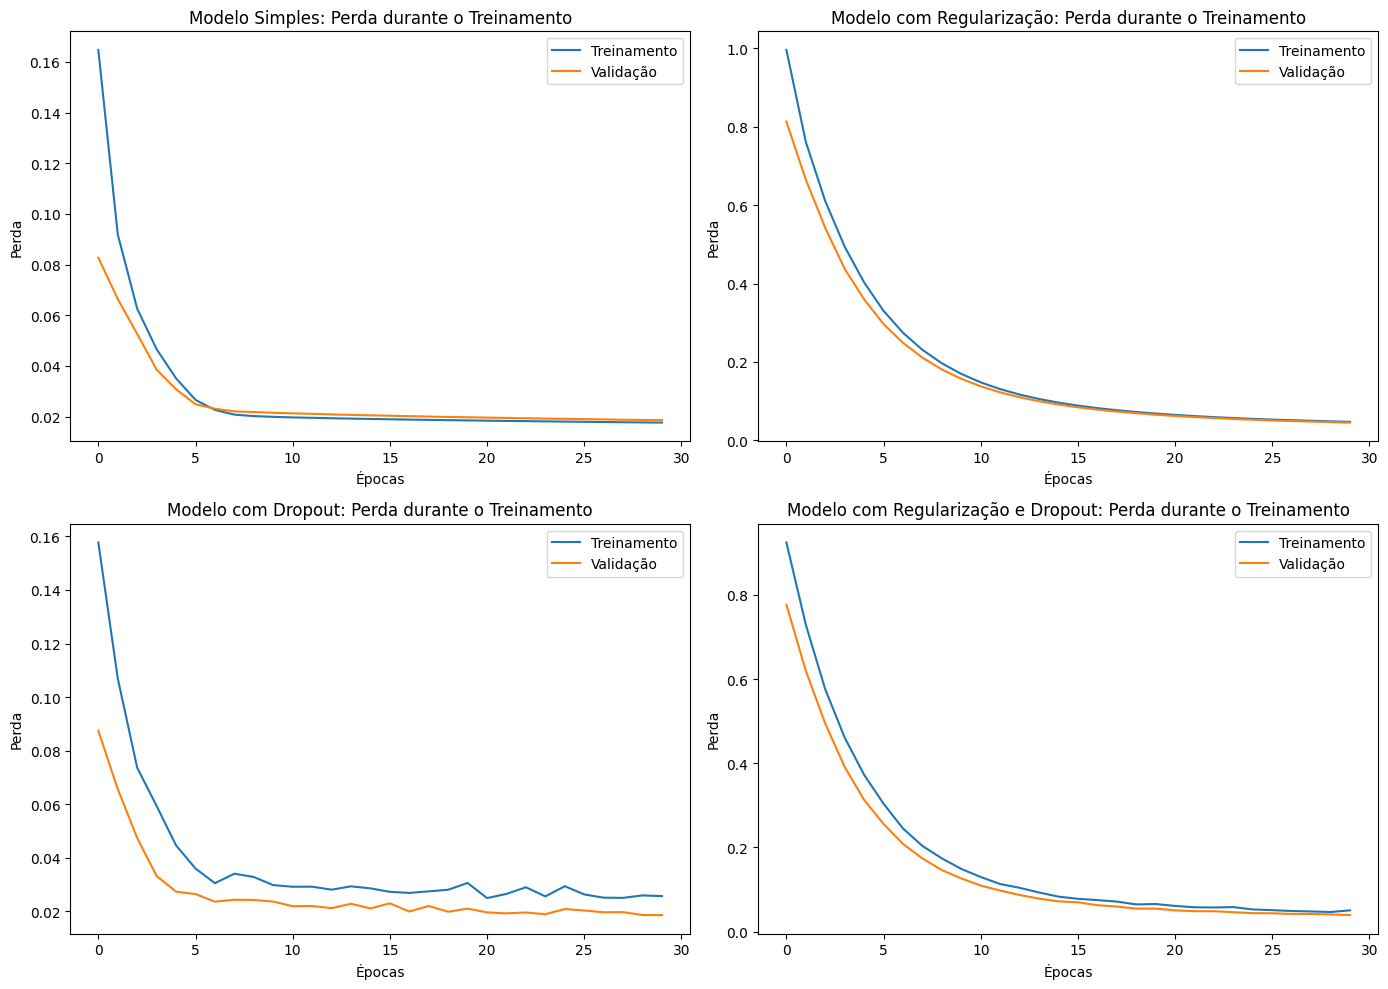

In [97]:
#Plot do Grafico de Perda
plot_multiple_loss(history_cnn, history_cnn_reg, history_cnn_drop, history_cnn_reg_drop)

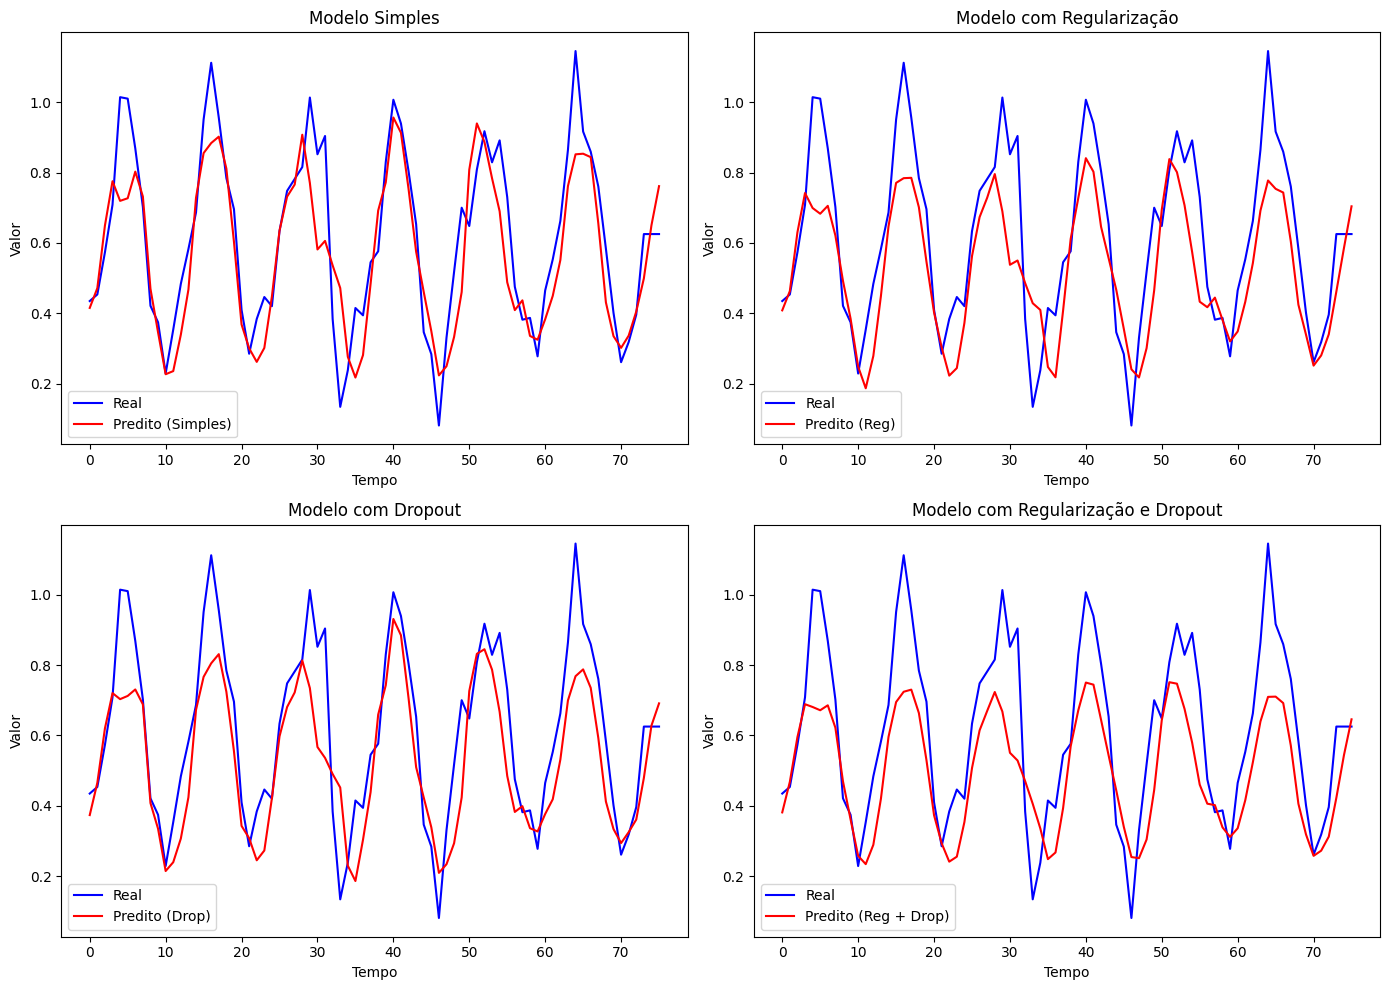

In [98]:
plot_predicts(y_pred_cnn, y_pred_cnn_reg, y_pred_cnn_drop, y_pred_cnn_reg_drop)

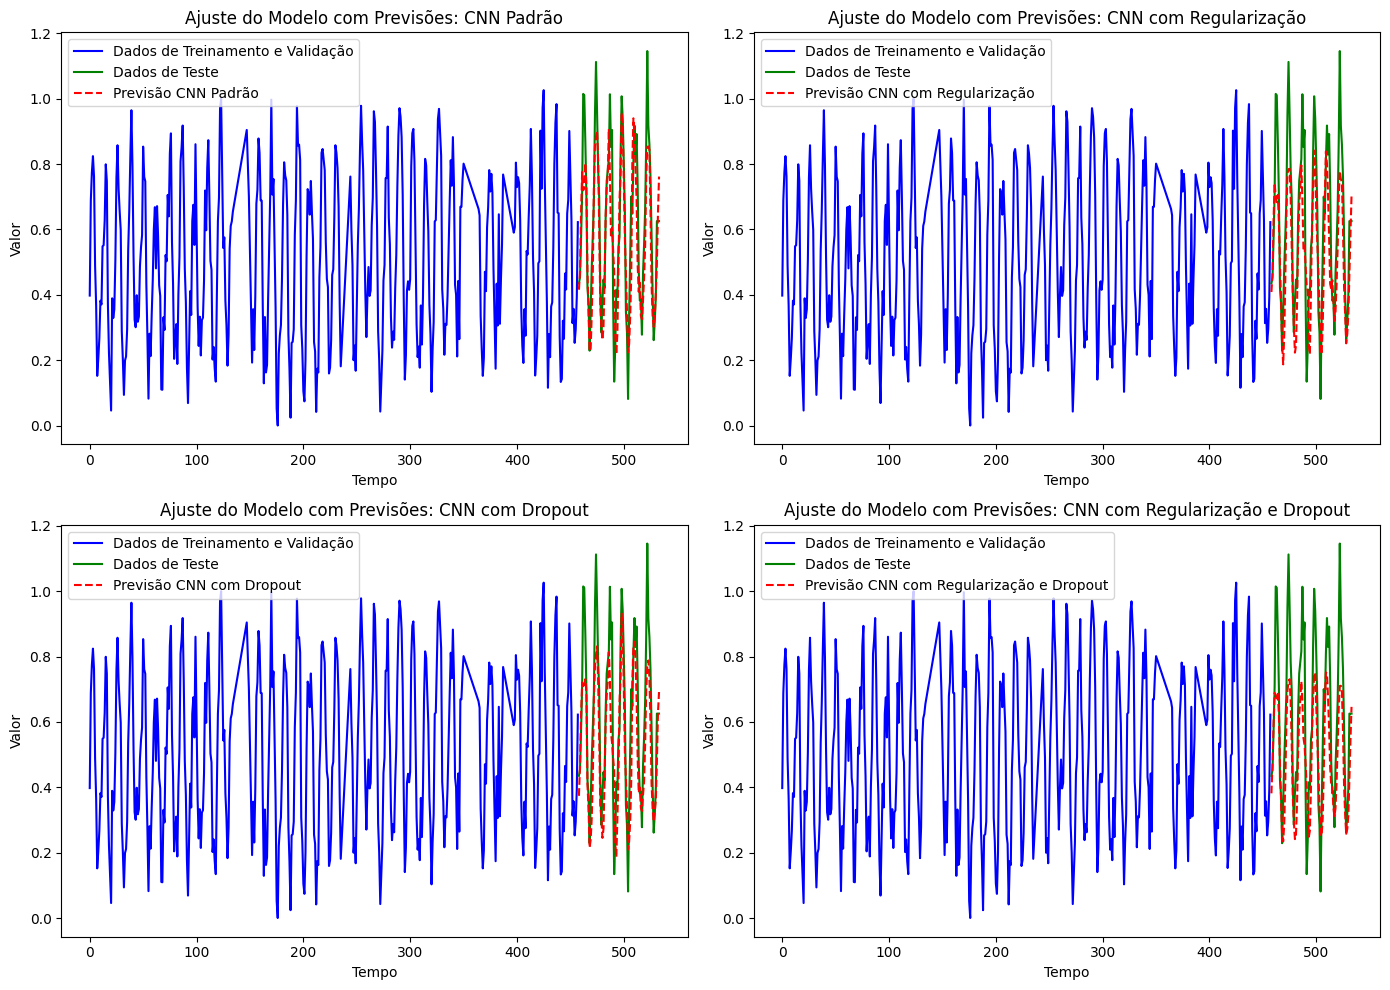

In [99]:
# Combine os dados de treino e validação em uma série para comparação visual com o conjunto de teste e previsões.
train_valid_data = np.concatenate([Y_train, Y_valid])  # Combina Y_train e Y_valid em uma série contínua

# Lista com previsões e nomes dos modelos para plotar
y_pred_models = [y_pred_cnn, y_pred_cnn_reg, y_pred_cnn_drop, y_pred_cnn_reg_drop]
model_names = ["CNN Padrão", "CNN com Regularização", "CNN com Dropout", "CNN com Regularização e Dropout"]

# Chamando a função para exibir os gráficos lado a lado
plot_multiple_predictions(train_valid_data, Y_test, y_pred_models, model_names)

# LSTM for Time Series Forecasting

* Now the LSTM model actually sees the input data as a sequence, so it's able to learn patterns from sequenced data (assuming it exists) better than the other ones, especially patterns from long sequences.
* Input shape **[samples, timesteps, features]**.

## Pre-procesamento dos dados

In [ ]:
#Hiperparametros
epochs_lstm = 50
batch_lstm = 32
lr_lstm = 0.001

## Implementacao e Ajuste do Modelo LSTM

In [ ]:
model_lstm = Sequential()
model_lstm.add(LSTM(50, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mse', optimizer=optimizers.Adam(lr_lstm))
#model_lstm.summary()

In [ ]:
history_lstm = model_lstm.fit(X_train_series,
                              Y_train,
                              validation_data=(X_valid, Y_valid),
                              epochs=epochs_lstm,
                              batch_size = batch_lstm,
                                verbose=1)

## Implementacao e Ajuste do Modelo LSTM com Regularizacao L2

In [ ]:
model_lstm_reg = Sequential()
model_lstm_reg.add(LSTM(50, activation='relu', kernel_regularizer=regularizers.l2(0.01), input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_lstm_reg.add(Dense(1))
model_lstm_reg.compile(optimizer=optimizers.Adam(lr_lstm), loss='mse')
#model_lstm_reg.summary()


In [ ]:
# Treinamento do modelo com regularização L2
# history_lstm_reg = model_lstm_reg.fit(X_train_series,
#                                       y_train,
#                                       epochs=epochs_lstm,
#                                       batch_size=32,
#                                       validation_split= 0.15,
#                                       verbose=2)

history_lstm_reg = model_lstm_reg.fit(X_train_series,
                              Y_train,
                              validation_data=(X_valid, Y_valid),
                              epochs=epochs_lstm,
                              batch_size = batch_lstm,
                                verbose=1)


## Implementacao e Ajuste do Modelo LSTM com Dropout

In [ ]:
model_lstm_drop = Sequential()
model_lstm_drop.add(LSTM(50, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_lstm_drop.add(Dropout(0.3))
model_lstm_drop.add(Dense(1))
model_lstm_drop.compile(optimizer=optimizers.Adam(lr_lstm), loss='mse')
#model_lstm_dropout.summary()


In [ ]:
# Treinamento do modelo com Dropout
history_lstm_drop = model_lstm_drop.fit(X_train_series,
                                              Y_train,
                                              epochs=epochs_lstm,
                                              batch_size=batch_lstm,
                                              validation_data=(X_valid, Y_valid),
                                              verbose=1)


## Implementacao e Ajuste do Modelo LSTM com Regularizacao e Dropout

In [ ]:
model_lstm_reg_drop = Sequential()
model_lstm_reg_drop.add(
    LSTM(
        50,
        activation='relu',
        kernel_regularizer=regularizers.l2(0.01),  # Regularização L2
        input_shape=(X_train_series.shape[1], X_train_series.shape[2])
    )
)
model_lstm_reg_drop.add(Dropout(0.3))
model_lstm_reg_drop.add(Dense(1))
model_lstm_reg_drop.compile(loss='mse', optimizer=optimizers.Adam(lr_lstm))
#model_lstm_reg_dropout.summary()


In [ ]:
history_lstm_reg_drop = model_lstm_reg_drop.fit(X_train_series,
                            Y_train,
                            epochs=epochs_lstm,
                            batch_size=batch_lstm,
                            validation_data=(X_valid, Y_valid),
                            verbose=2)

# history_lstm_drop = model_lstm_drop.fit(X_train_series,
#                                               Y_train,
#                                               epochs=epochs_lstm,
#                                               batch_size=32,
#                                               validation_data=(X_valid_series, Y_valid),
#                                               verbose=1)

## Comparativo entre os modelos - Predicao e Validacao

In [ ]:
# Avaliação de cada modelo no conjunto de teste
mae_standard, mse_standard, rmse_standard, mape_standard = evaluate_model(model_lstm, X_test, Y_test, "Modelo Padrão")
mae_reg, mse_reg, rmse_reg, mape_reg = evaluate_model(model_lstm_reg, X_test, Y_test, "Modelo com Regularização")
mae_dropout, mse_dropout, rmse_dropout, mape_dropout = evaluate_model(model_lstm_drop, X_test, Y_test, "Modelo com Dropout")
mae_reg_drop, mse_reg_drop, rmse_reg_drop, mape_reg_drop = evaluate_model(model_lstm_reg_drop, X_test, Y_test, "Modelo com Regularização e Dropout")

In [ ]:
#Plot do Grafico de Perda
plot_multiple_loss(history_lstm, history_lstm_reg, history_lstm_drop, history_lstm_reg_drop)

In [ ]:
# Obtendo as previsões dos quatro modelos
y_pred_lstm = model_lstm.predict(X_test)
y_pred_lstm_reg = model_lstm_reg.predict(X_test)
y_pred_lstm_drop = model_lstm_drop.predict(X_test)
y_pred_lstm_reg_drop = model_lstm_reg_drop.predict(X_test)

In [ ]:
plot_predicts(y_pred_lstm, y_pred_lstm_reg, y_pred_lstm_drop, y_pred_lstm_reg_drop)

In [ ]:
# Combine os dados de treino e validação em uma série para comparação visual com o conjunto de teste e previsões.
train_valid_data = np.concatenate([Y_train, Y_valid])  # Combina Y_train e Y_valid em uma série contínua

# Lista com previsões e nomes dos modelos para plotar
y_pred_models = [y_pred_lstm, y_pred_lstm_reg, y_pred_lstm_drop, y_pred_lstm_reg_drop]
model_names = ["LSTM Padrão", "LSTM com Regularização", "LSTM com Dropout", "LSTM com Regularização e Dropout"]

# Chamando a função para exibir os gráficos lado a lado
plot_multiple_predictions(train_valid_data, Y_test, y_pred_models, model_names)

# CNN-LSTM for Time Series Forecasting
* Input shape **[samples, subsequences, timesteps, features]**.

#### Model explanation from the [article](https://machinelearningmastery.com/how-to-get-started-with-deep-learning-for-time-series-forecasting-7-day-mini-course/)
> "The benefit of this model is that the model can support very long input sequences that can be read as blocks or subsequences by the CNN model, then pieced together by the LSTM model."
>
> "When using a hybrid CNN-LSTM model, we will further divide each sample into further subsequences. The CNN model will interpret each sub-sequence and the LSTM will piece together the interpretations from the subsequences. As such, we will split each sample into 2 subsequences of 2 times per subsequence."
>
> "The CNN will be defined to expect 2 timesteps per subsequence with one feature. The entire CNN model is then wrapped in TimeDistributed wrapper layers so that it can be applied to each subsequence in the sample. The results are then interpreted by the LSTM layer before the model outputs a prediction."

#### Data preprocess
* Reshape from [samples, timesteps, features] into [samples, subsequences, timesteps, features].

## Pre-processamento dos dados

In [ ]:
#Hiperparametros
epochs_hibrid = 30
batch_hibrid = 32
lr_hibrid = 0.001
subsequences = 2

In [ ]:
timesteps = X_train.shape[1]//subsequences
X_train_series_sub = X_train.reshape((X_train.shape[0], subsequences, timesteps, 1))
X_valid_series_sub = X_valid.reshape((X_valid.shape[0], subsequences, timesteps, 1))
X_test_series_sub = X_test.reshape((X_test.shape[0], subsequences, timesteps, 1))
print('Train set shape', X_train_series_sub.shape)
print('Validation set shape', X_valid_series_sub.shape)
print('Test set shape', X_test_series_sub.shape)

## Implementacao e ajuste do modelo padrao

In [ ]:
model_cnn_lstm = Sequential()
model_cnn_lstm.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, X_train_series_sub.shape[2], X_train_series_sub.shape[3])))
model_cnn_lstm.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model_cnn_lstm.add(TimeDistributed(Flatten()))
model_cnn_lstm.add(LSTM(50, activation='relu'))
model_cnn_lstm.add(Dense(1))
model_cnn_lstm.compile(loss='mse', optimizer=optimizers.Adam(lr_hibrid))

In [ ]:
history_cnn_lstm = model_cnn_lstm.fit(X_train_series_sub,
                                      Y_train,
                                      validation_data=(X_valid_series_sub, Y_valid),
                                      epochs=epochs_hibrid,
                                      batch_size = batch_hibrid,
                                      verbose=1)

## Implementacao e Ajuste do modelo com Regularizacao

In [ ]:
model_cnn_lstm_reg = Sequential()
model_cnn_lstm_reg.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu', kernel_regularizer=regularizers.l2(0.001)), input_shape=(None, X_train_series_sub.shape[2], X_train_series_sub.shape[3])))
model_cnn_lstm_reg.add(TimeDistributed(MaxPooling1D(pool_size=1)))
model_cnn_lstm_reg.add(TimeDistributed(Flatten()))
model_cnn_lstm_reg.add(LSTM(50, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model_cnn_lstm_reg.add(Dense(1))
model_cnn_lstm_reg.compile(loss='mse', optimizer=optimizers.Adam(lr_hibrid))

In [ ]:
history_cnn_lstm_reg = model_cnn_lstm_reg.fit(X_train_series_sub,
                                              Y_train,
                                              validation_data=(X_valid_series_sub, Y_valid),
                                              epochs=epochs_hibrid,
                                              batch_size = batch_hibrid,
                                              verbose=1)


## Implementacao e Ajuste do Modelo com Dropout

In [ ]:
model_cnn_lstm_drop = Sequential()
model_cnn_lstm_drop.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, X_train_series_sub.shape[2], X_train_series_sub.shape[3])))
model_cnn_lstm_drop.add(TimeDistributed(MaxPooling1D(pool_size=1)))
model_cnn_lstm_drop.add(TimeDistributed(Flatten()))
model_cnn_lstm_drop.add(Dropout(0.3))
model_cnn_lstm_drop.add(LSTM(50, activation='relu'))
model_cnn_lstm_drop.add(Dropout(0.3))
model_cnn_lstm_drop.add(Dense(1))
model_cnn_lstm_drop.compile(loss='mse', optimizer=optimizers.Adam(lr_hibrid))

In [ ]:
history_cnn_lstm_drop = model_cnn_lstm_drop.fit(X_train_series_sub,
                                                Y_train,
                                                validation_data=(X_valid_series_sub, Y_valid),
                                                epochs=epochs_hibrid,
                                                batch_size = batch_hibrid,
                                                verbose=1)


## Implementacao e Ajuste do Modelo com Regularizacao e Dropout

In [ ]:
model_cnn_lstm_reg_drop = Sequential()
model_cnn_lstm_reg_drop.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu', kernel_regularizer=regularizers.l2(0.001)), input_shape=(None, X_train_series_sub.shape[2], X_train_series_sub.shape[3])))
model_cnn_lstm_reg_drop.add(TimeDistributed(MaxPooling1D(pool_size=1)))
model_cnn_lstm_reg_drop.add(TimeDistributed(Flatten()))
model_cnn_lstm_reg_drop.add(Dropout(0.3))
model_cnn_lstm_reg_drop.add(LSTM(50, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model_cnn_lstm_reg_drop.add(Dropout(0.3))
model_cnn_lstm_reg_drop.add(Dense(1))
model_cnn_lstm_reg_drop.compile(loss='mse', optimizer=optimizers.Adam(lr_hibrid))

history_cnn_lstm_reg_drop = model_cnn_lstm_reg_drop.fit(X_train_series_sub,
                                                        Y_train,
                                                        validation_data=(X_valid_series_sub, Y_valid),
                                                        epochs=epochs_hibrid,
                                                        batch_size = batch_hibrid,
                                                        verbose=1)


## Comparativo entre os modelos

In [ ]:
# Realizando previsões para cada modelo
y_pred_cnn_lstm = model_cnn_lstm.predict(X_test_series_sub)
y_pred_cnn_lstm_reg = model_cnn_lstm_reg.predict(X_test_series_sub)
y_pred_cnn_lstm_drop = model_cnn_lstm_drop.predict(X_test_series_sub)
y_pred_cnn_lstm_reg_drop = model_cnn_lstm_reg_drop.predict(X_test_series_sub)


In [ ]:
# # Cálculo das métricas para cada modelo
# metrics = {
#     "Modelo LSTM": {
#         "MAPE": mean_absolute_percentage_error(Y_test, y_pred_cnn_lstm),
#         "MSE": mean_squared_error(Y_test, y_pred_cnn_lstm),
#         "RMSE": root_mean_squared_error(Y_test, y_pred_cnn_lstm)
#     },
#     "Modelo LSTM com Regularização": {
#         "MAPE": mean_absolute_percentage_error(Y_test, y_pred_cnn_lstm_reg),
#         "MSE": mean_squared_error(Y_test, y_pred_cnn_lstm_reg),
#         "RMSE": root_mean_squared_error(Y_test, y_pred_cnn_lstm_reg)
#     },
#     "Modelo LSTM com Dropout": {
#         "MAPE": mean_absolute_percentage_error(Y_test, y_pred_cnn_lstm_drop),
#         "MSE": mean_squared_error(Y_test, y_pred_cnn_lstm_drop),
#         "RMSE": root_mean_squared_error(Y_test, y_pred_cnn_lstm_drop)
#     },
#     "Modelo LSTM com Regularização e Dropout": {
#         "MAPE": mean_absolute_percentage_error(Y_test, y_pred_cnn_lstm_reg_drop),
#         "MSE": mean_squared_error(Y_test, y_pred_cnn_lstm_reg_drop),
#         "RMSE": root_mean_squared_error(Y_test, y_pred_cnn_lstm_reg_drop)
#     }
# }

# # Exibir as métricas
# for model, values in metrics.items():
#     print(f"{model}: MAPE={values['MAPE']:.2f}%, MSE={values['MSE']:.4f}, RMSE={values['RMSE']:.4f}")

In [ ]:
# Avaliação de cada modelo no conjunto de teste
mae_standard, mse_standard, rmse_standard, mape_standard = evaluate_model(model_cnn_lstm, X_test_series_sub, Y_test, "Modelo Padrão")
mae_reg, mse_reg, rmse_reg, mape_reg = evaluate_model(model_cnn_lstm_reg, X_test_series_sub, Y_test, "Modelo com Regularização")
mae_dropout, mse_dropout, rmse_dropout, mape_dropout = evaluate_model(model_cnn_lstm_drop, X_test_series_sub, Y_test, "Modelo com Dropout")
mae_reg_drop, mse_reg_drop, rmse_reg_drop, mape_reg_drop = evaluate_model(model_cnn_lstm_reg_drop, X_test_series_sub, Y_test, "Modelo com Regularização e Dropout")

In [ ]:
#Plot do Grafico de Perda
plot_multiple_loss(history_cnn_lstm, history_cnn_lstm_reg, history_cnn_lstm_drop, history_cnn_lstm_reg_drop)

In [ ]:
plot_predicts(y_pred_cnn_lstm, y_pred_cnn_lstm_reg, y_pred_cnn_lstm_drop, y_pred_cnn_lstm_reg_drop)

In [ ]:
# Combine os dados de treino e validação em uma série para comparação visual com o conjunto de teste e previsões.
train_valid_data = np.concatenate([Y_train, Y_valid])  # Combina Y_train e Y_valid em uma série contínua

# Lista com previsões e nomes dos modelos para plotar
y_pred_models = [y_pred_cnn_lstm, y_pred_cnn_lstm_reg, y_pred_cnn_lstm_drop, y_pred_cnn_lstm_reg_drop]
model_names = ["CNN-LSTM Padrão", "CNN-LSTM com Regularização", "CNN-LSTM com Dropout", "CNN-LSTM com Regularização e Dropout"]

# Chamando a função para exibir os gráficos lado a lado
plot_multiple_predictions(train_valid_data, Y_test, y_pred_models, model_names)